## Extracting 5 stars reviews


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')   

In [3]:
movies['movie_id_reset'] = movies.index + 1
movies.head()

,movieId,title,genres,movie_id_reset
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,2
2,3,Grumpier Old Men (1995),Comedy|Romance,3
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,4
4,5,Father of the Bride Part II (1995),Comedy,5


In [4]:
# substitute movieid with movie id reset in ratings
movieid_to_reset = dict(zip(movies['movieId'], movies['movie_id_reset']))
ratings['movie_id_reset'] = ratings['movieId'].map(movieid_to_reset)
ratings

,userId,movieId,rating,timestamp,movie_id_reset
0,1,17,4.0,944249077,17
1,1,25,1.0,944250228,25
2,1,29,2.0,943230976,29
3,1,30,5.0,944249077,30
4,1,32,5.0,943228858,32
...,...,...,...,...,...
32000199,200948,79702,4.5,1294412589,15059
32000200,200948,79796,1.0,1287216292,15078
32000201,200948,80350,0.5,1294412671,15213
32000202,200948,80463,3.5,1350423800,15241


<Axes: >

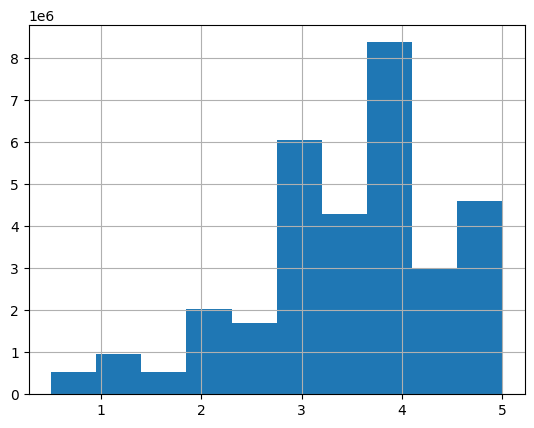

In [5]:
ratings.rating.hist(bins=10)
# float((ratings.rating == 5).sum() / len(ratings) ). # 14%

In [6]:
ratings5s = ratings[ratings.rating == 5]
len(ratings5s)

4596577

Text(0, 0.5, 'Number of users')

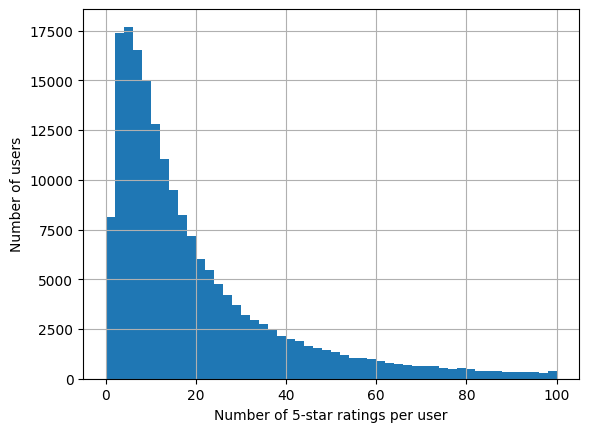

In [7]:
ratings5s.groupby('userId').size().hist(bins=50, range=(0, 100))
plt.xlabel('Number of 5-star ratings per user')
plt.ylabel('Number of users')

In [8]:
ratings5s[['userId', 'movie_id_reset']].to_csv('data/ratings5s.csv', index=False)
movies.to_csv('data/movies_cleaned.csv', index=False)

## Prediction

In [1]:
from argparse import Namespace
from model import SASRec
import numpy as np
import torch

In [2]:

def load_args_from_file(config_content):
    args = Namespace()
    
    # Define type conversions based on the original argparse types
    type_map = {
        'batch_size': int, 'lr': float, 'maxlen': int, 'hidden_units': int,
        'num_blocks': int, 'num_epochs': int, 'num_heads': int, 
        'dropout_rate': float, 'l2_emb': float, 'inference_only': lambda s: s.lower() == 'true',
        'norm_first': lambda s: s.lower() == 'true',
        'dataset': str, 'train_dir': str, 'device': str, 'state_dict_path': str,
        'usernum': int, 'itemnum': int
    }

    for line in config_content.strip().split('\n'):
        if not line or ',' not in line: continue
        key, value_str = line.split(',', 1)
        key = key.strip()
        value_str = value_str.strip()
        
        # Apply type conversion
        if key in type_map:
            try:
                if key == 'state_dict_path' and value_str.lower() == 'none':
                    value = None
                else:
                    value = type_map[key](value_str)
            except ValueError:
                value = value_str # Default to string if conversion fails
        else:
            value = value_str
            
        setattr(args, key, value)
    return args

In [3]:
args_path = '/Users/stefano/Documents/projects/Movie-Recommendation/results/ratings_5stars_default/args.txt'
model_path = '/Users/stefano/Documents/projects/Movie-Recommendation/results/ratings_5stars_default/SASRec.epoch=30.lr=0.001.layer=2.head=1.hidden=50.maxlen=200.pth'

with open(args_path, 'r') as f: 
    config_content = f.read()

args = load_args_from_file(config_content)

model = SASRec(args.usernum, args.itemnum, args)
model.load_state_dict(torch.load(model_path, map_location=torch.device(args.device)))

<All keys matched successfully>

In [4]:
seq = np.zeros([args.maxlen], dtype=np.int32)
idx = args.maxlen - 1

my_movies = [48780, 55247, 104374, 1246, 1704, 3424, 153548]

for movie in reversed(my_movies):
    seq[idx] = movie
    idx -= 1


In [25]:
model.eval()
# input_seq = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(args.device)  # (1, maxlen)
with torch.no_grad():
    predictions = model.predict(seq.reshape(1, -1), torch.arange(args.itemnum))

scores = predictions.squeeze(0).cpu().numpy()  # (itemnum,)
top_items = np.argsort(-scores)[:10] 
print("Top recommended movie IDs:", top_items)

Top recommended movie IDs: [270698 287699 274053 202439 254726 223876 170487 195159 250010 201340]


In [20]:
seq.reshape(1, -1).shape

(1, 200)

In [26]:
args.itemnum

292241